# Web scraping

In this class we will begin a web scraping project. We will return to the theme of web scraping later this semester, once we are comfortable with a wider collection of tools. 

Web scraping involves writing code to *obtain data from the internet*, and to *re-structure* it in a way that it is *useful*.  Depending on how *cooperative* your on-line sources are, there is a varying amount of work one needs to do, including various levels of automation. 

We will focus on some of the simplest web-scraping tasks here, in large part to practice Python programming techniques.

## Description of a problem

In the summer of 2016, Professor X made a few small changes to his house.  He would like to know if his changes made any real difference in the energy-efficiency of his house.  The house is mostly heated with electric base-board heaters.  Towards this end, we have some data available:

* <a href="https://www.bchydro.com/index.html">BC Hydro</a> (Professor X's electricity supplier) provides energy usage data for its customers in downloadable spreadsheets. The data comes in various resolutions (hourly, daily, etc).  We have daily data in our directory, kindly supplied by Professor X, starting in 2015, going until January 2017. 

* Stats Canada similarly provides downloadable weather data on its <a href="http://climate.weather.gc.ca/historical_data/search_historic_data_e.html">Historical Weather Database. </a>  The relevant data for Victoria has similarly been downloaded and put in this directory. 

This project involves three main steps. 

**Step 1**: Download the data.  This has been done for us, but as you can imagine, depending on the webpage this might take rather sophisticated techniques.  Web pages don't always give you their data in downloadable spreadsheets.  Sometimes they are hidden in menus, require authorization, require clicking in specific buttons that are rendered by specialized protocols (Javascript, Flash player, etc).  We will explore this step in more detail for *less cooperative* on-line sources.  For this project, the data has kindly been supplied. 

**Step 2**: Assemble the data into a relevant format we can use for analysis.  

**Step 3**: Do some analysis.  We will make a few plots, and consider a few variations on how we choose to look at our data. 

### Step 2, part (a) -- the weather data

We will store the weather data as Python **lists** *[time/date, weather data]* which we can sort on the time/date field. . . This allows us to not worry very much about the order the data is loaded into memory. 

The spreadsheets **.csv** files, these are <a href="https://en.wikipedia.org/wiki/ASCII">ASCII</a> files, that can be read in any text editor.  

* As we can see from inspection, there are several initial lines that give some context to the spreadsheet.  

* There is a line which indicates what kind of data is in each column.  

* The data appears, one line at a time.  Each column is separated by a comma. 

* Each row is separated by a <a href="https://en.wikipedia.org/wiki/Carriage_return">carriage return</a>.  

* The csv files all have the form eng-daily*.csv so this is how we will load them. 

For the time/date information, Python supplies the convenient *datetime* library. 

In [1]:
import datetime as dt
import os as os
import fnmatch as fn

files = fn.filter(os.listdir('.'), "eng-daily*.csv")
## iteratively load the files, grab and parse lines. . .
wdatlist = []
for i in range(len(files)):
    ## we need to add the encoding and errors flag because WENDI can't
    ## parse unicode characters. 
    with open("./"+files[i], encoding='utf-8', errors='ignore') as f:
        content = f.readlines()
        ## in the daily spreadsheets line 25 is the descriptions, 26+ is the items.
        ## in the hourly spreadsheets line 16 and 17+
        for j in range(26, len(content)):
            ab = content[j].split(",")
            for k in range(len(ab)): # this removes the quotes around the numbers.
                ab[k] = ab[k].translate({ord(c): None for c in '"'})
                ## this code choice is made so that we can remove characters from
                ## unicode strings -- unicode is an increasingly popular text file
                ## format. 
            date = dt.date(int(ab[1]), int(ab[2]), int(ab[3])) ## get date.
            ## throw out days where we lack the relevant data for. . .
            if (len(ab[5])>0 and len(ab[7])>0 and len(ab[9])>0):
                wdatlist.append([date, float(ab[5]), float(ab[7]), float(ab[9])])

#let's sort it on the date, just in case we loaded the files in the wrong order.
from operator import itemgetter
wdatlist = sorted(wdatlist, key=itemgetter(0))

<IPython.core.display.Javascript object>


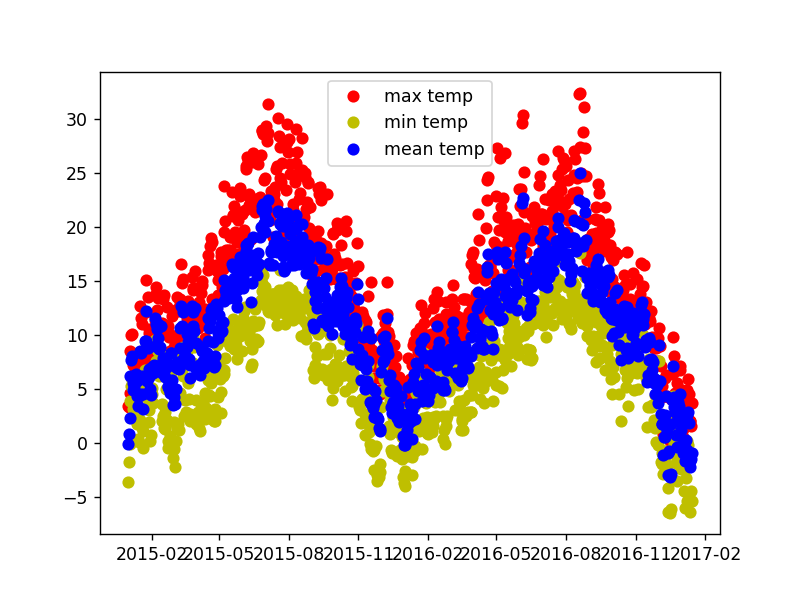

In [2]:
## A simple plot to get a sense for the data

import matplotlib.pyplot as plt
%matplotlib nbagg
plt.close()

## let's make the x-axis the date, 
## and the        y-axis will have max, min and average temperatures.

x = [p[0] for p in wdatlist]
y1 = [p[1] for p in wdatlist] # max
y2 = [p[2] for p in wdatlist] # min
y3 = [p[3] for p in wdatlist] # mean

plt.plot(x,y1, 'ro', label = "max temp")
plt.plot(x,y2, 'yo', label = "min temp")
plt.plot(x,y3, 'bo', label = "mean temp")
plt.legend()

### Step 2, part (b) -- Energy Data

Now we do the same for the energy data. 

* The description of the columns is on line 4. 
* Data starts on line 5+. 
* Date format is Y/M/D, column 1. 
* Energy consumption is kWh, column 2. 


In [3]:
files = fn.filter(os.listdir('./'), "BCHydro.daily*.csv")
edatlist = []
for i in range(len(files)):
    with open("./"+files[i]) as f:
        content = f.readlines()
        for j in range(5, len(content)):
            ab = content[j].split(",")
            for k in range(len(ab)):
                ab[k] = ab[k].translate({ord(c): None for c in '"'})
            date = dt.datetime.strptime(ab[1],'%Y/%m/%d %H:%M:%S').date()
            if (ab[2]!='N/A'):
                edatlist.append([date, float(ab[2])])

## sort edatlist, to ensure data is in historical order. 
edatlist = sorted(edatlist, key=itemgetter(0))

<IPython.core.display.Javascript object>


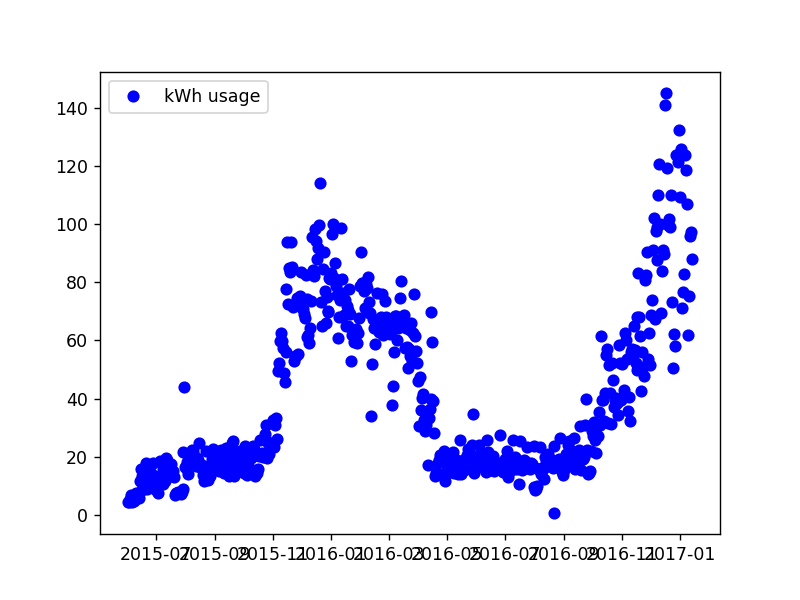

In [4]:
plt.close() # remember to close previous plot

x = [p[0] for p in edatlist]
y = [p[1] for p in edatlist] # max

plt.plot(x,y, 'bo', label = "kWh usage")
plt.legend()

### Step 3: Basic analysis of the data

Power consumption appears (sometimes) larger in the 2016-2017 winter compared with 2015-2016, but there are also colder days.  Let's try to compare power usage for similar-temperature days. For this we will merge the data sets into one *bdatlist*. 

* Want to make plots of temperatures vs. electricity costs for the two periods.  
* We can make the x-axis average temperature
* The y-axis can be cost. 
* Let's break the colors up into:
  - red for summer 2016 and earlier.
  - blue for fall 2016 and later. 


<IPython.core.display.Javascript object>


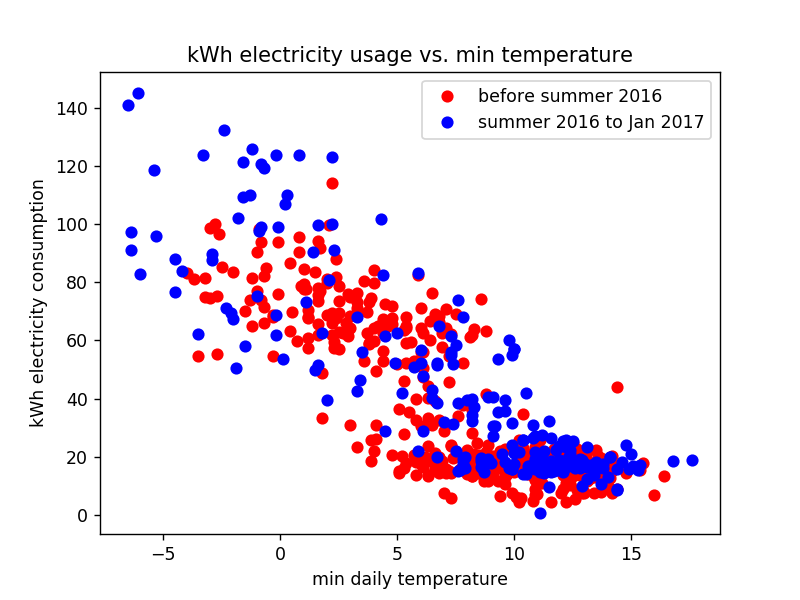

In [5]:
## step 1: find the dates we have both temperatures and kWh usage, put them into a big list
##         [date, max temp, min temp, mean temp, kWh usage]
##
##  we will run through wdatlist, and look for the date in edatlist

bdatlist = []
for x in wdatlist:
    res = [element for element in edatlist if element[0] == x[0]]
    if (len(res)>0):
        bdatlist.append([x[0], x[1], x[2], x[3], res[0][1]])

bdatlist0 = []
bdatlist1 = []
for x in bdatlist:
    if (x[0] < dt.date(2016,6,1)):
        bdatlist0.append(x)
    else:
        bdatlist1.append(x)
        
import matplotlib.pyplot as plt
%matplotlib nbagg

## we need the x and y coordinates as lists, for the <2016 data
## and the x and y coordinates for the >2016 data. 
x1 = [bdatlist0[i][2] for i in range(len(bdatlist0))]
y1 = [bdatlist0[i][4] for i in range(len(bdatlist0))]

x2 = [bdatlist1[i][2] for i in range(len(bdatlist1))]
y2 = [bdatlist1[i][4] for i in range(len(bdatlist1))]

plt.plot(x1,y1, 'ro', label="before summer 2016")
plt.plot(x2,y2, 'bo', label="summer 2016 to Jan 2017")
plt.title("kWh electricity usage vs. min temperature")
plt.xlabel("min daily temperature")
plt.ylabel("kWh electricity consumption")
plt.legend()

### Step 3 continued: other plots to consider? 

* Weekends vs non-weekends? 
* kWh averages for given temperatures? 
* Use average temperatures rather than min? 

In [ ]:
## Let's try computing kWh averages for every degree c, using rounding
plt.close()

## start by building a list: [(temp, [energy use readings])]
##  then we compute averages. 
import collections as co

table5m = co.defaultdict(list) ## min temps and energy usage, 2015-2016
table5M = co.defaultdict(list) ## mean temps and energy usage, 2015-2016
table6m = co.defaultdict(list) ## min temps and energy usage 2016-2017
table6M = co.defaultdict(list) ## mean temps and energy usage, 2016-2017
for b in bdatlist0:
    ## b = [date, max, min, mean, Euse]
    table5m[round(b[2])].append(b[4])
    table5M[round(b[3])].append(b[4])
for b in bdatlist1:
    table6m[round(b[2])].append(b[4])
    table6M[round(b[3])].append(b[4])
    
avg5m = co.defaultdict(float)
avg5M = co.defaultdict(float)
avg6m = co.defaultdict(float)
avg6M = co.defaultdict(float)
for x in table5m:
    avg5m[x] = sum(table5m[x])/len(table5m[x])
for x in table5M:
    avg5M[x] = sum(table5M[x])/len(table5M[x])
for x in table6m:
    avg6m[x] = sum(table6m[x])/len(table6m[x])
for x in table6M:
    avg6M[x] = sum(table6M[x])/len(table6M[x])

## we need to sort lowest to highest (temperature)
## otherwise the plot will not satisfy the vertical line rule
avg5m = co.OrderedDict(sorted(avg5m.items()))
avg5M = co.OrderedDict(sorted(avg5M.items()))
avg6m = co.OrderedDict(sorted(avg6m.items()))
avg6M = co.OrderedDict(sorted(avg6M.items()))

x5m = [x for x in avg5m]
y5m = [avg5m[x] for x in avg5m]
x5M = [x for x in avg5M]
y5M = [avg5M[x] for x in avg5M]

x6m = [x for x in avg6m]
y6m = [avg6m[x] for x in avg6m]
x6M = [x for x in avg6M]
y6M = [avg6M[x] for x in avg6M]

plt.plot(x5m, y5m, 'y-', label='2015-2016 (min T)')
#plt.plot(x5M, y5M, 'r-', label='2015-2016 (mean T)')
plt.plot(x6m, y6m, 'b-', label='2016-2017 (min T)')
#plt.plot(x6M, y6M, 'g-', label='2016-2017 (mean T)')
plt.xlabel('min temperature')
plt.ylabel('average energy usage on those days')

plt.legend()

## Automated web scraping

Let's consider some basic data-harvesting problems that could use automation. 

* The <a href="https://developers.google.com/maps/documentation/elevation/intro">Google elevation API</a> is a web-interface set up by Google to give elevation data for any coordinate on earth (in metres).  We will attempt some basic web-scraping of the Google page. 

* The <a href="https://www.wunderground.com/weather/api/">Weather Underground API</a> allows automated exploration of weather data from hundreds of thousands of weather stations all over the planet. 

### Scraping the Google elevation website

The google website is one of the simplest to scrape.  We provide the website with our request on the *https* request.  It provides us with a custom website, basically a text file, in response. 

* The response is in <a href="http://www.json.org/">JSON</a> a standard structured text-file format.  

* Although JSON is human-readable, it is also very closely related to the Python *dict* and *list* data types.  The **json** library allows for easy conversion between JSON files and Python objects. 

* We will use the *urllib* library to access the internet.  This is good accessing data on basic *http* webpages.  Webpages that use further enhancements like <a href="https://www.javascript.com/">Javascript</a> and <a href="https://get.adobe.com/flashplayer/?no_redirect">Flash</a> require more sophisticated web-scraping tools that we will explore later in the course. 

In [ ]:
import json as js ## many web pages provide data in the JSON format, this helps us read it.
from urllib.request import urlopen ## URLlib is one of the most "basic" libraries for accessing webpages.
import time as ti ## Web pages tend to block users that ask for too much data too quickly.  This library
 ## lets us put delays into our code.

In [ ]:
## Let's request from Google the elevation of the roof in the building we're in. 

f=urlopen("https://maps.googleapis.com/maps/api/elevation/json?"
                  "locations=48.464958,-123.313418")
#print(f.read())
json_string = f.read().decode('utf-8')
print(json_string)

In [ ]:
jsl = js.loads(json_string)
print(type(jsl))
print(jsl)
print(jsl['status'])

In [ ]:
## Let's request the elevation of Mount Everest.  We find its longitude and latitude from Wikipedia

## 27°59′17″N 86°55′31″E --> 27.9881° N, 86.9253° E converted. 

f=urlopen("https://maps.googleapis.com/maps/api/elevation/json?"
          "locations=27.9881,86.9253")
json_string = f.read().decode('utf-8')
jsl = js.loads(json_string)
print(jsl['results'][0]['elevation'], 'metres')

## Scraping Weather Underground

<a href="https://www.wunderground.com/">**Weather Underground**</a> is a webpage for a network of home weather enthusiasts on the internet.  There are hundreds of thousands of home <a href="https://www.amazon.com/s?field-keywords=weather+station">weather stations</a> around the planet, connected to the internet reporting real-time weather data. 

In this code we will do some very elementary web scraping from Weather Underground.  **Weather Underground** is a heavily-mined website by people's cell phones, internet companies, news stations, etc.  So they put restrictions on  the amount (and frequency) of access.  This website demands users register and get an **API Key** to access the site. How to get an API is described <a href="https://www.wunderground.com/weather/api/d/docs">here</a> as well as how to format one's *http* requests. 

If you want to execute this code, you will need to generate a Weather Underground API key. Go to the
<a href="https://www.wunderground.com/weather/api/">Weather Underground API 


In [ ]:
## to complete this project you will have to 
import wundergroundkey as wk

## "WeatherStructure" is the name of this data type. 
## If X is a WStruct, you can call its attributes by: x.StationID, x.assoc, etc. 
WStruct = co.namedtuple("WeatherStructure", "StationID assoc neighbourhood city province country lat lon elev time weather temp_c humid wind_string wind_dir wind_deg wind_kph pressure_mb dewpt_c precip_today")

## Give this routine a station ID, it will return a WStruct associated to the station
def FetchWeather(fStationID):
    URL_string = "http://api.wunderground.com/api/"+wk.WAPI+"/geolookup/conditions/q/pws:"+fStationID+".json"
    #print(fStationID, end="", flush=True)
    URLobj = urlopen(URL_string)
    #print(". ",end="", flush=True)
    json_string = URLobj.read().decode('utf-8')
    parsed_json = js.loads(json_string) ## This creates an index for reading the file
    
    # We will use this dictionary-object to build the retval, a WStruct type. 
    adj_pws_stations = parsed_json['location']['nearby_weather_stations']['pws']['station']
    nearby_stations = [ adj_pws_stations[i]['id'] for i in range(len(adj_pws_stations)) ]
    
    # Return the WStruct
    return WStruct(StationID = fStationID, assoc = nearby_stations, neighbourhood = \
                   adj_pws_stations[0]['neighborhood'], \
                   city = parsed_json['current_observation']['display_location']['city'], \
                   province = parsed_json['current_observation']['display_location']['state_name'], \
                   country = parsed_json['current_observation']['display_location']['country'], \
                   lat = parsed_json['current_observation']['display_location']['latitude'], \
                   lon = parsed_json['current_observation']['display_location']['longitude'], \
                   elev = parsed_json['current_observation']['display_location']['elevation'], \
                   time = parsed_json['current_observation']['observation_time'], \
                   weather = parsed_json['current_observation']['weather'], \
                   temp_c = parsed_json['current_observation']['temp_c'], \
                   humid = parsed_json['current_observation']['relative_humidity'], \
                   wind_string = parsed_json['current_observation']['wind_string'],\
                   wind_dir = parsed_json['current_observation']['wind_dir'], \
                   wind_deg = parsed_json['current_observation']['wind_degrees'], \
                   wind_kph = parsed_json['current_observation']['wind_kph'], \
                   pressure_mb = parsed_json['current_observation']['pressure_mb'], \
                   dewpt_c = parsed_json['current_observation']['dewpoint_c'], \
                   precip_today = parsed_json['current_observation']['precip_today_metric'])

f = FetchWeather("IBRITISH479")
print(f.weather, ", ", f.temp_c, " deg c", sep='')

# Homework Assignment 1

Your first homework assignment builds on the first few lectures, and our Week 2 and Week 3 labs. It is available [here](../Homework/asst.1.ipynb). 

In [ ]:
import sys
print(sys.version)